In [ ]:
%pip install torch torchvision transformers scikit-learn torch-directml seaborn matplotlib numpy

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   -- ------------------------------------- 2.1/39.0 MB 10.7 MB/s eta 0:00:04
   ----- ---------------------------------- 5.5/39.0 MB 13.4 MB/s eta 0:00:03
   ---------- ----------------------------- 10.0/39.0 MB 15.9 MB/s eta 0:00:02
   -------------- ------------------------- 14.2/39.0 MB 16.8 MB/s eta 0:00:02
   ------------------- -------------------- 18.9/39.0 MB 18.0 MB/s eta 0:00:02
   ----------------------- ---------------- 23.1/39.0 MB 18.7 MB/s eta 0:00:01
   ---------------------------- ----------- 28.0/39.0 MB 19.1 MB/s eta 0:00:01
   --------------------------------- ------ 32.8/39.0 MB 19.6 MB/s eta 0:00:01
   -------------------------------------- - 37.5/39.0 MB 20.0 MB/s eta 0:00:01
   ---------------------------------------- 39.0/39.0 MB 19.4 MB/s  0:00:02
Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch_directml
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import ViTConfig, ViTForImageClassification
from torch.optim import AdamW
from transformers.models.vit.modeling_vit  import ViTPatchEmbeddings
from sklearn.model_selection import train_test_split

In [9]:
class EmotionDataset(Dataset):
    def __init__(self, dataframe, image_directory, transform=None, mode='train'):
        self.data_frame = dataframe
        self.img_directory = image_directory
        self.transform = transform
        self.mode = mode

        self.image_col = 'image'
        self.label_col = 'emotion'

    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        row = self.data_frame.iloc[idx]
        image_name = row[self.image_col]
        image_path = os.path.join(self.img_directory, image_name)
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        if self.mode == 'train' or self.mode == 'val':
            label_idx = int(row['label_idx'])
            return image, label_idx
        else:
            return image, image_name

In [4]:
# configuration for model
BATCH_SIZE = 64
NUM_CLASSES = 8
DEVICE = torch_directml.device()

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

Labels: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
Training samples: 10952, Validation samples: 2738, Total samples: 13690


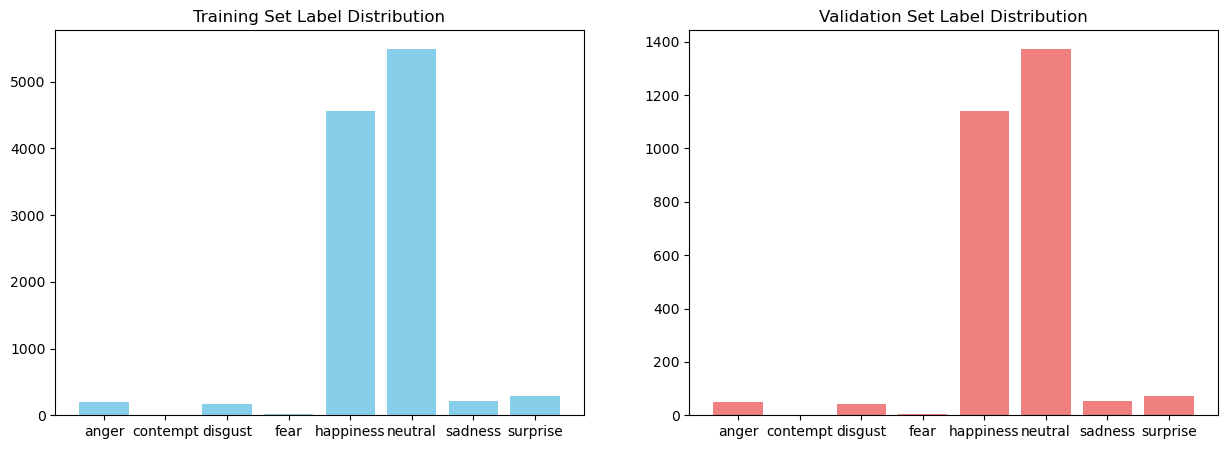

Training label distribution:
anger: 202
contempt: 7
disgust: 166
fear: 17
happiness: 4557
neutral: 5494
sadness: 215
surprise: 294


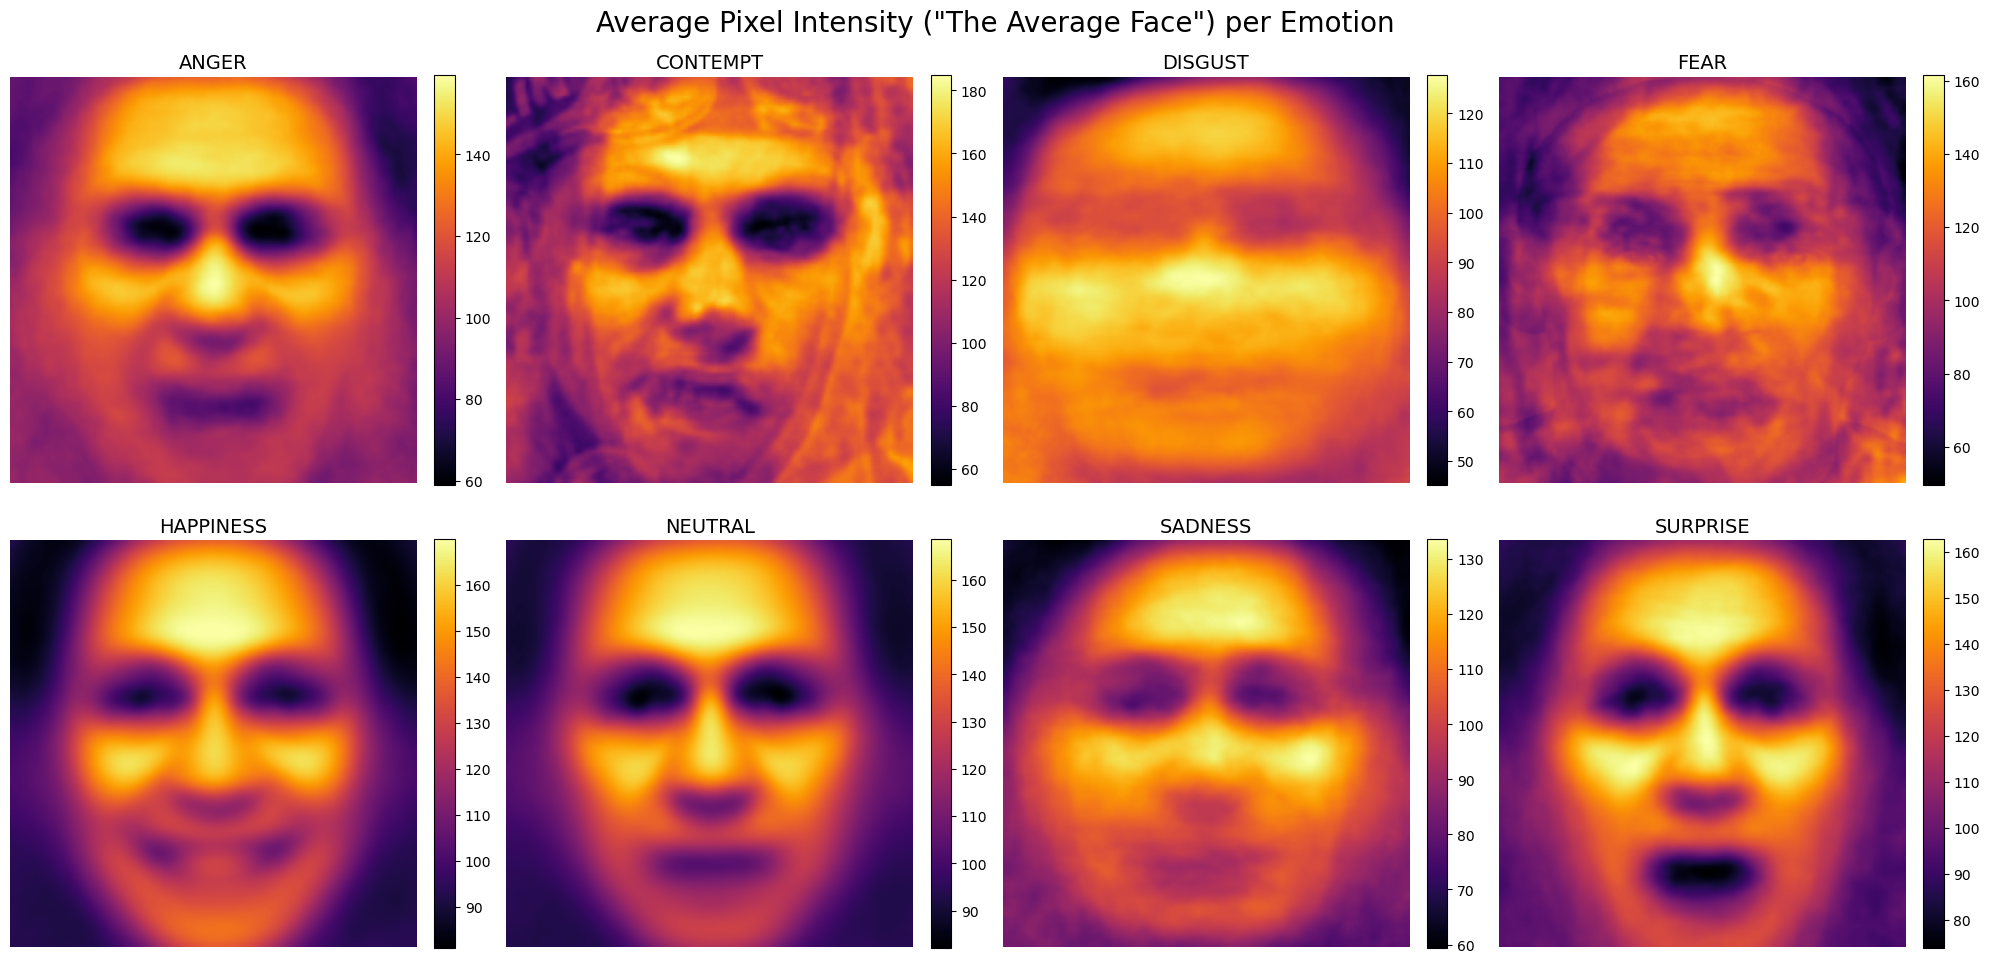

In [47]:
# load datasets
full_data = pd.read_csv('../data/legend.csv')
full_data['label_idx'] = full_data['emotion'].str.lower()

unique_labels = sorted(full_data['label_idx'].unique())
label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_to_label = {i: label for label, i in label_to_int.items()}
full_data['label_idx'] = full_data['label_idx'].map(label_to_int)
print(f"Labels: {unique_labels}")


# split data
train_df, val_df = train_test_split(full_data, test_size=0.2, stratify=full_data['label_idx'], random_state=42)
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}, Total samples: {len(full_data)}")


# create datasets and dataloaders
train_dataset = EmotionDataset(train_df, '../images/', transform=train_transform, mode='train')
val_dataset = EmotionDataset(val_df, '../images/', transform=test_transform, mode='val')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


# visualize label distribution
from matplotlib import pyplot as plt
train_counts = train_df['label_idx'].value_counts().sort_index()
val_counts = val_df['label_idx'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].bar([int_to_label[i] for i in train_counts.index], train_counts.values, color='skyblue')
axes[0].set_title('Training Set Label Distribution')
axes[1].bar([int_to_label[i] for i in val_counts.index], val_counts.values, color='lightcoral')
axes[1].set_title('Validation Set Label Distribution')
plt.show()

print("Training label distribution:")
for i, count in train_counts.items():
    print(f"{int_to_label[i]}: {count}")

# visualize heatmap
def get_average_face(emotion, df, img_dir, num_samples=13690):
    subset = df[df['label_idx'] == label_to_int[emotion]]
    
    if len(subset) > num_samples:
        subset = subset.sample(num_samples, random_state=42)
        
    img_data = []
    
    for img_name in subset['image']:
        try:
            path = os.path.join(img_dir, img_name)
            img = Image.open(path).convert('L').resize((224, 224))
            img_data.append(np.array(img))
        except:
            pass
            
    # calculate mean across all images
    if not img_data:
        return np.zeros((224, 224))
        
    return np.mean(img_data, axis=0)

# plot heatmaps
plt.figure(figsize=(20, 10))
plt.suptitle('Average Pixel Intensity ("The Average Face") per Emotion', fontsize=20)

for i, emotion in enumerate(unique_labels):
    avg_face = get_average_face(emotion, full_data, '../images/', num_samples=13690)
    
    plt.subplot(2, 4, i + 1)
    plt.imshow(avg_face, cmap='inferno') 
    plt.title(emotion.upper(), fontsize=14)
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [40]:
# model setup
config = ViTConfig(
    image_size = 224,
    patch_size = 16,
    num_labels = NUM_CLASSES,
    hidden_size = 256,
    num_hidden_layers = 8,
    num_attention_heads = 4,
    intermediate_size = 512,
    hidden_dropout_prob = 0.1
)

class ConvStem(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, config.hidden_size, kernel_size=3, stride=2, padding=1),
        )
        
        self.weight = nn.Parameter(torch.randn(config.hidden_size, 3, config.patch_size, config.patch_size))
        self.bias = None
    
    def forward(self, pixel_values):
        x = self.conv_layers(pixel_values)
        return x.flatten(2).transpose(1, 2)

class CustomViT(ViTPatchEmbeddings):
    def __init__(self, config):
        super().__init__(config)
        self.projection = ConvStem(config)

model = ViTForImageClassification(config)

class CustomPatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.projection = ConvStem(config)
        self.num_patches = (config.image_size // config.patch_size) ** 2
        
    def forward(self, pixel_values, interpolate_pos_encoding=False):
        embeddings = self.projection(pixel_values)
        return embeddings

model.vit.embeddings.patch_embeddings = CustomPatchEmbeddings(config)
model.to(DEVICE)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): CustomPatchEmbeddings(
        (projection): ConvStem(
          (conv_layers): Sequential(
            (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU()
            (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (8): ReLU()
            (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          )
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ViTE

In [52]:
# plot variables
train_losses = []
val_losses = []
accuracies = []

# train model
optimizer = AdamW(model.parameters(), lr=5e-4)  
criterion = nn.CrossEntropyLoss()
num_epochs = 50

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)   # move data back to gpu

        optimizer.zero_grad()                                   # zero the parameter gradients
        outputs = model(images).logits                          # forward pass to capture global relationships between features
        loss = criterion(outputs, labels)                       # compute loss
        loss.backward()                                         # backpropagation
        optimizer.step()                                        # update model parameters using AdamW optimizer

        running_loss += loss.item() * images.size(0)            # multiplies loss tensor by batch size to get total loss for the batch

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # validation check
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images).logits                          # forward pass during validation
            loss = criterion(outputs, labels)                       # compute validation loss
            val_loss += loss.item() * images.size(0)                # accumulate validation loss

            _, predicted = torch.max(outputs.data, 1)               # get predictions
            total += labels.size(0)                                 # total number of labels
            correct += (predicted == labels).sum().item()           # count correct predictions
    
    val_epoch_loss = val_loss / len(val_dataset)
    val_accuracy = 100 * correct / total

    val_losses.append(val_epoch_loss)
    accuracies.append(val_accuracy)
    
    print(f"Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

Starting training...
Epoch [1/50], Loss: 0.9843
Validation Loss: 0.9761, Accuracy: 52.23%
Epoch [2/50], Loss: 0.9799
Validation Loss: 0.9711, Accuracy: 52.12%
Epoch [3/50], Loss: 0.9762
Validation Loss: 0.9692, Accuracy: 52.23%


KeyboardInterrupt: 

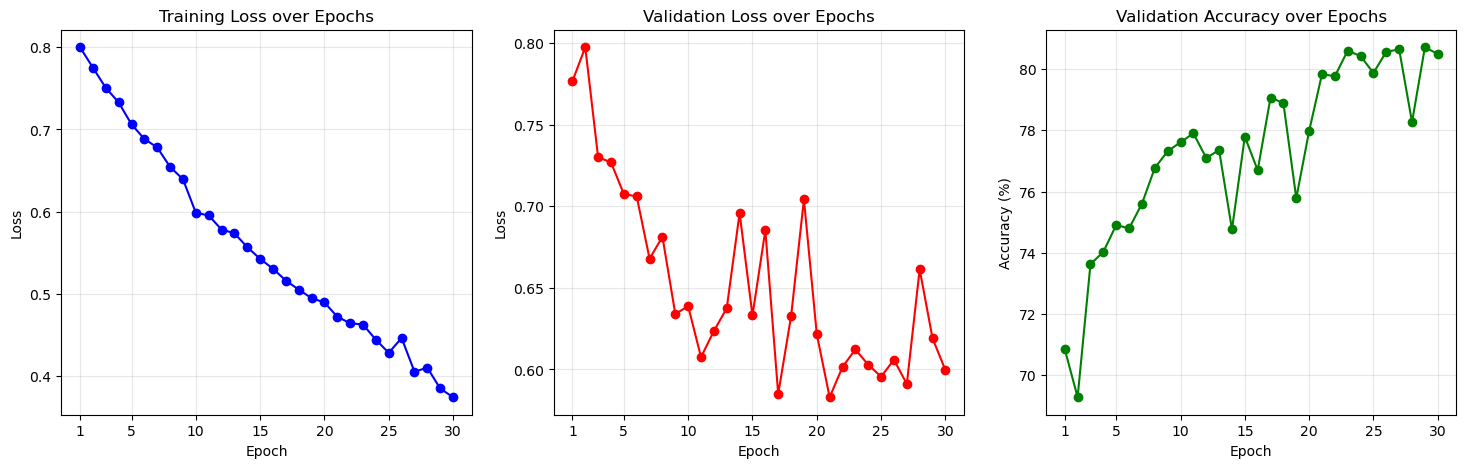

In [23]:
# plot training loss curve
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# training loss
axes[0].plot(range(1, num_epochs + 1), train_losses, 'b-', marker='o')
axes[0].set_title('Training Loss over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_xticks([1, 5, 10, 15, 20, 25, 30])
axes[0].grid(True, alpha = 0.3)

# validation loss
axes[1].plot(range(1, num_epochs + 1), val_losses, 'r-', marker='o')
axes[1].set_title('Validation Loss over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks([1, 5, 10, 15, 20, 25, 30])
axes[1].grid(True, alpha = 0.3)

# accuracy
axes[2].plot(range(1, num_epochs + 1), accuracies, 'g-', marker='o')
axes[2].set_title('Validation Accuracy over Epochs')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy (%)')
axes[2].set_xticks([1, 5, 10, 15, 20, 25, 30])
axes[2].grid(True, alpha = 0.3)
plt.show()

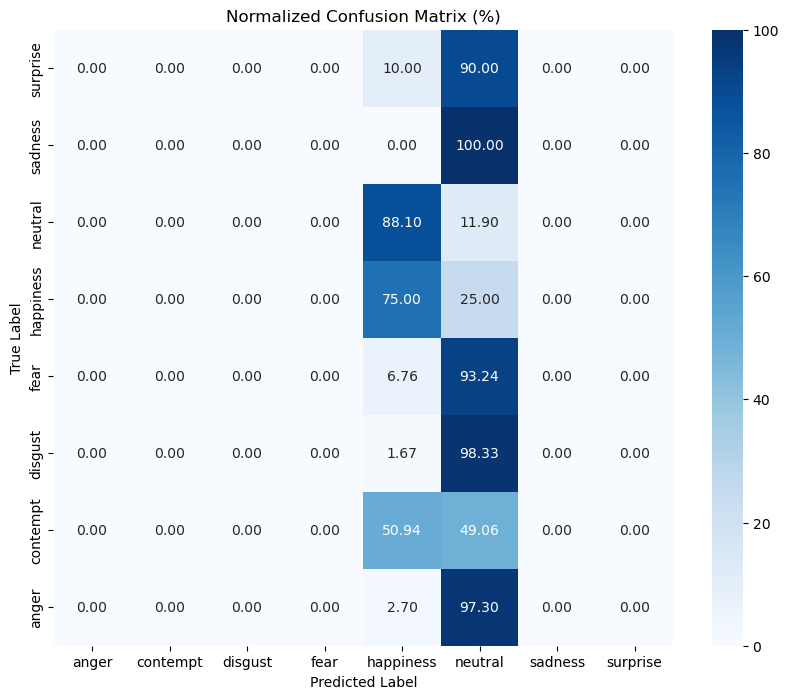


Per-class accuracy:
anger: 0.00%
contempt: 0.00%
disgust: 0.00%
fear: 0.00%
happiness: 6.76%
neutral: 98.33%
sadness: 0.00%
surprise: 0.00%

Weighted F1-Score: 0.3931


In [49]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)
        outputs = model(images).logits
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels[::-1])
plt.title('Normalized Confusion Matrix (%)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nPer-class accuracy:")
for i, label in enumerate(unique_labels):
    print(f"{label}: {cm_normalized[i, i]:.2f}%")

# f1-score
from sklearn.metrics import f1_score
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f"\nWeighted F1-Score: {f1:.4f}")